# Elementary Particles Notebook
## From Acceleration to Discovery

In the lecture we have broadly seen the process from particle acceleration to particle discovery. In this notebook we will look very specifically at that last step and try to find the Higgs boson ourselves in data made public by the ATLAS experiment.

Use this notebook as reference material for the assignements of the tutorial belonging to the "From Acceleration to Discovery" lecture.

---
## Importing packages
We start by importing the packages we will need to load the data and display the results.

In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.26/10


---
## Loading data
We then load the data that we want to analyze. As mentioned, this is data that has been made public by the ATLAS experiment. Unfortunately, it is only a subset of the total dataset, so you will probably not be able to make new discoveries with it. Nevertheless, it is cool to remember that these are *really measured* data.

In [2]:
f = ROOT.TFile.Open("https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_D.GamGam.root")

In [3]:
tree = f.Get("mini")

The `tree` variable now contains all the information we need. To begin with, let's see exactly how many events we have to analyze.

In [4]:
aantal_events = tree.GetEntries()
print(aantal_events)

3602176


That's quite a few events! Before we can *really* use it, we need to learn two things:

1. what information is stored from each event?
2. what coordinate system is used to store spatial information (such as particle direction of motion)?

---
## Event information
To get the information from events in the tree, we need to tell the tree which event to open. We do this with the `GetEvent` method. This method, or function, does not return any event information, but is an internal pointer that indicates which event you are currently looking at. For example, we can find out the number of leptons for the first event with the following commands:

In [5]:
tree.GetEvent(0)
print(tree.lep_n)

1


Note that `tree.GetEvent(0)` indeed gives no output. The number of leptons in the second event, accessed via `tree.GetEvent(1)`, is different from that of the first event, as we can see via:

In [6]:
tree.GetEvent(1)
print(tree.lep_n)

0


---
### Intermezzo: coordinate system

The spatial information of particles is stored in a coordinate system $(\eta, \phi, p_T)$, or (pseudorapidity, azimuthal angle, transverse momentum).

The **transverse momentum** is the magnitude of the momentum projected onto the plane perpendicular to the beams, with the origin at the point of interaction. The **pseudorapidity** is an encoding of the angle $\theta$ making a particle with the incoming beam:

$$\eta \equiv -\ln \left[ \tan\left(\frac{\theta}{2}\right)\right]$$

The translation between $\theta$ and $\eta$ can be seen in the following image

![Vertaling naar pseudorapiditeit](https://upload.wikimedia.org/wikipedia/commons/3/30/Pseudorapidity2.png)

The reason to use $\eta$ instead of $\theta$ is that it points (partly) in the direction of the bunches. Because in a collision the resulting velocity in this direction is rarely zero, this direction is sensitive to Lorentz contraction. Differences between pseudorapidity are Lorentz invariant, so we prefer this coordinate system.

---

Let's go back to the first event and find the spatial information of one lepton in that event:

In [7]:
# Select first event
tree.GetEvent(0)
# Print spatial information
print(tree.lep_n)
print("Pseudorapidity:      ", tree.lep_eta[0])
print("Azimuthal angle:       ", tree.lep_phi[0])
print("Transverse momentum: ", tree.lep_pt[0])

1
Pseudorapidity:       -0.057872429490089417
Azimuthal angle:        -0.3258419334888458
Transverse momentum:  45225.75390625


OK, that works. Note that we approach the values ​​for `lep_eta`, `lep_phi` and `lep_pt` as if they were a list. For example, if the event contained more than one lepton, we could use `tree.lep_eta[1]` to find the pseudorapidity of the second lepton.

We can find the type of particle with

In [8]:
tree.lep_type[0]

13

This number most likely means nothing to you. This number is defined in a standardized *Particle Numbering Scheme*, which can be found in [the PDG documentation](https://pdg.lbl.gov/2006/reviews/pdf-files/montecarlo-web.pdf). There you will find that the number 13 corresponds to a muon. If you want the electric charge of a particle, you can get it with

In [9]:
tree.lep_charge[0]

-1

---
## Other objects
In addition to leptons, events naturally also consist of other objects. In the same way as above, we can also extract information from the event about:

- jets: the objects resulting from colored particles (quarks and gluons). For example: `jet_n` and `jet_phi[0]`;
- photons, for example with `photon_n` and `photon_eta[1]`;
- the missing transversal momentum. For this we can only find out the angle `met_phi` and the magnitude `met_et`. It represents the missing energy and the direction in which this energy is missing.

You can use the command `tree.Print()` to get a list of all the information stored in the tree of events. There are many "branches" in this tree, but for now you can look at those of the type `object_property`, as for `lep_E` which is a vector storing the energy of the leptons in a given event. For a complete description of these variables, please refer to https://cds.cern.ch/record/2707171/files/ANA-OTRC-2019-01-PUB-updated.pdf (Appendix A).


In [10]:
tree.Print()

******************************************************************************
*Tree    :mini      : mini                                                   *
*Entries :  3602176 : Total =      3487367045 bytes  File  Size =  686855345 *
*        :          : Tree compression factor =   5.08                       *
******************************************************************************
*Br    0 :runNumber : runNumber/I                                            *
*Entries :  3602176 : Total  Size=   14411693 bytes  File Size  =      71944 *
*Baskets :       25 : Basket Size=    1872384 bytes  Compression= 197.89     *
*............................................................................*
*Br    1 :eventNumber : eventNumber/I                                        *
*Entries :  3602176 : Total  Size=   14411755 bytes  File Size  =   13354596 *
*Baskets :       25 : Basket Size=    1872384 bytes  Compression=   1.07     *
*...................................................

---

## Finally: Finding Higgs
Now, with all this knowledge, let's try to find the Higgs. The process we are going to look at is

$$H \rightarrow \gamma \gamma.$$

To discover the Higgs, we need to find out the invariant mass of the Higgs, and (because that value is invariant) of the two photons. We will leave the formula for this unexplained for now.

In [11]:
def invariante_massa_2(pt1, pt2, eta1, eta2, phi1, phi2):
    return 2*pt1*pt2*(np.cosh(eta1-eta2) - np.cos(phi1 - phi2))

We want to store these invariant masses for later plotting in a histogram (the standard method for presenting these kinds of results). For this reason we create a list to store the results.

In [12]:
invariante_massas = []

We could now loop over all events with a `for` loop, selecting them one by one with `GetEvent()`. However, this is a bit cumbersome, because it can also be done immediately with

    for event in tree:

This does this for us right away, so we don't need a `GetEvent()` statement anymore.

In this loop, we're going to do two kinds of things:

1. We are going to select events by their properties. Only events that have the right properties should be included in our analysis.
2. We are going to calculate the invariant masses for the events that survived our cuts and store it in `invariant_mass`.

Which properties do we want to select on? Well, our final state contains two photons, so we're going to discard any event that contains less than 2 photons. We could, with a more complicated analysis, also use events with more than 2 photons, but to keep the simplicity we discard those as well.

All this gives us the following analysis:

In [13]:
for i, event in enumerate(tree):
    # Stop the analysis when we have analyzed more than 10000 events.
    # We do this to finish faster. For a full analysis
    # we remove this if statement.
    if i > 1e3:
        break
    # Print how far you are now
    if (i+1)%10000 == 0:
        print("Analyseren van event {} van de {}".format(i+1, aantal_events))
        
    # Ignore all events with != 2 photons
    if tree.photon_n != 2:
        continue
        
    # Calculate the invariant mass of the remaining events
    s = np.sqrt( invariante_massa_2(
        tree.photon_pt[0], tree.photon_pt[1],
        tree.photon_eta[0], tree.photon_eta[1],
        tree.photon_phi[0], tree.photon_phi[1],
    ))
    invariante_massas.append( s/1000 )
    
print("Done!")

Done!


We then make the histogram very easily with matplotlib

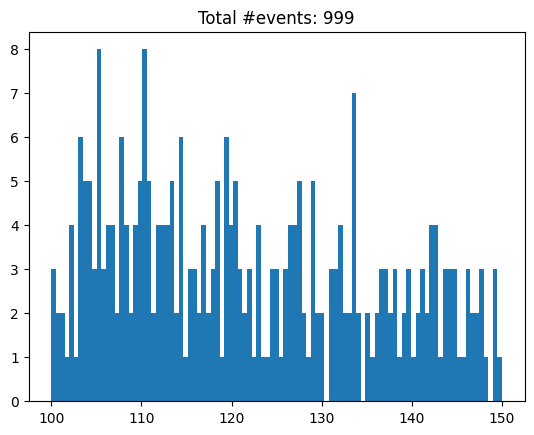

In [14]:
bins = np.linspace(100, 150, 100)
plt.hist(invariante_massas, bins)
plt.title("Total #events: {}".format(len(invariante_massas)))
plt.show()

Unfortunately, we don't see a peak around 125 GeV :( The reasons are:

- we could use a more sophisticated selection: only requiring two photons in the event is not enough to isolate the **signal**;
- we needed more data! The **signal** is hidden in the statistical fluctuations of the histogram.

